In [3]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import gen_l96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [4]:
# Lorenz96の設定
J = 40
F = 8
lorenz = gen_l96(F)

# 同化step
# 時間発展は0.01ごとに行う
Dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# Dtは同化step
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1.0
R = r*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l96.npy')[:end_step]
y = np.load('x_obs_l96.npy')[:end_step]
if not np.isclose(r, 1.0):
    y = x_true + np.random.normal(loc=0, scale=np.sqrt(r), size=x_true.shape) # R = r*I

# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*I


In [5]:
# RUN DA
etkf = ETKF(M, H, R, x_0, P_0, m=41, alpha=1.0, seed=seed, store_ensemble=True)
for y_obs in y:
    etkf.forecast(Dt)
    etkf.update(y_obs)

x_assim = etkf.x

KeyboardInterrupt: 

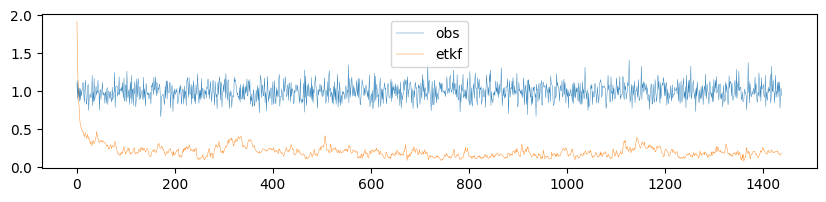

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true, y, loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='etkf', lw=0.3)
ax.legend()
# ax.set_ylim([0, 2])
plt.show()